In [5]:
import sys
import os
import ctypes


# Get the absolute path of the utils directory
utils_path = os.path.abspath("lib")
sys.path.append("../lib")
sys.path.append(utils_path)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import qiskit.qpy as qpy
import pickle
import json
import matplotlib.patches as mpatches
from numba import njit
from numba.typed import List
from plotting import *
from readings import *
from tile_process import *

In [8]:
class TilePacker:
    def __init__(self, *args):
        # Sort tiles by area once during initialization
        if len(args) <= 2:
            print("Construct based on unplaced tiles")
            if len(args) == 2:
                tiles = args[0]
                twoCut = args[1]
            else:
                tiles = args[0]
                twoCut = False
            self.tiles = tiles
            if not twoCut:
                self.tiles = sorted(tiles, key=lambda x: sum(w * h for w, h, _, _ in x), reverse=True)
            self.placed_tiles = []
            self.bounding_width = 0
            self.bounding_height = max(dy + h for tile in tiles for _, h, _, dy in tile)
        elif len(args) == 3:
            print("Construct based on placed tiles")
            placed_tiles = args[0]
            bounding_width = args[1]
            bounding_height = args[2]
            self.placed_tiles = placed_tiles
            self.bounding_width = bounding_width
            self.bounding_height = bounding_height
        
    def fits(self, x, tile, grid):
        """Check if a composite tile fits horizontally at position x."""
        for w, h, dx, dy in tile:
            # Check if it fits within the grid width
            if x + dx + w > grid.shape[1]:
                return False
            # Check if space is occupied in the grid (optimized check)
            if np.any(grid[dy:dy + h, x + dx:x + dx + w] == 1):
                return False
        return True

    def place_tile(self, tile, grid):
        """Find the best position to place a composite tile horizontally."""
        for x in range(grid.shape[1]):
            if self.fits(x, tile, grid):
                # Place the tile in the grid
                for w, h, dx, dy in tile:
                    grid[dy:dy + h, x + dx:x + dx + w] = 1
                return x  # Return x position where the tile is placed
        return -1  # Return -1 if the tile cannot be placed

    def pack_tiles(self):
        """Pack the tiles into a grid and return the bounding box dimensions."""
        max_width = sum(max(w + dx for w, _, dx, _ in tile) for tile in self.tiles)
        grid = np.zeros((self.bounding_height, max_width), dtype=int)
        count = 0

        # Precompute positions where each tile could fit
        fit_positions_cache = {}

        for tile in self.tiles:
            x_position = self.place_tile(tile, grid)
            if x_position == -1:
                print("Error: Tile doesn't fit, increase grid size.")
                break
            # Add the tile to placed tiles
            self.placed_tiles.append((x_position, tile))
            # Update bounding width
            self.bounding_width = max(self.bounding_width, x_position + max(dx + w for w, _, dx, _ in tile))

        return self.bounding_width, self.bounding_height, self.placed_tiles, grid

    def draw_packing(self, grid, seam_lst, epsilon, intra_color="tomato", inter_color="cyan", edge=False, box_lst = None, xmin = 0):
        """
        Draws the placement of tiles with color, boundaries, and sets the plot limits 
        to the min_x and max_x of the placed tiles.

        Args:
            grid: The grid containing the tile placement.
            seam_lst: List of seam positions.
            epsilon: Parameter for the plot title.
            intra_color: Color for intra-region tiles.
            inter_color: Color for inter-region tiles.
            edge: Whether to draw tile boundaries.
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_aspect('auto')

        # Initialize variables to track the min_x and max_x of placed tiles
        min_x = float('inf')
        max_x = float('-inf')

        # Draw each tile
        for idx, (tile_x, tile) in enumerate(self.placed_tiles):
            for w, h, dx, dy in tile:
                tile_left = tile_x + dx
                tile_right = tile_left + w

                # Update min_x and max_x based on tile positions
                min_x = min(min_x, tile_left)
                max_x = max(max_x, tile_right)

                # Draw tiles with boundaries
                if edge:
                    rect = patches.Rectangle((tile_left, dy), w, h, facecolor=intra_color, edgecolor="black", linewidth=1)
                else:
                    rect = patches.Rectangle((tile_left, dy), w, h, facecolor=intra_color)

                # Change color for inter-region tiles
                for seam in seam_lst:
                    if dy < seam and dy + h >= seam:
                        if edge:
                            rect = patches.Rectangle((tile_left, dy), w, h, facecolor=inter_color, edgecolor="black", linewidth=1)
                        else:
                            rect = patches.Rectangle((tile_left, dy), w, h, facecolor=inter_color)
                
                ax.add_patch(rect)

        # Set the plot limits based on the min_x and max_x of placed tiles
        margin_x = (max_x - min_x) * 0.05  # Add 5% margin to the width
        margin_y = self.bounding_height * 0.05  # Add 5% margin to the height

        ax.set_xlim(xmin, max_x)
        ax.set_ylim(0, self.bounding_height)

        # Hide axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Draw seams
        for seam in seam_lst:
            plt.axhline(seam - 0.5, color="purple", linewidth=2)
        
        # Draw box
        if box_lst:
            for line in box_lst:
                plt.axvline(line, color="red", linewidth=1)
        plt.title(f"circuit depth = {self.bounding_width}, epsilon = {epsilon}")
        plt.show()


In [10]:
N = 24; f_orbs = (2,2,2,2,2,2)
seam_lst = [8,16]
epsilon = 0.001
prehead = "../../data_H_12/"
uop, all_g = read_uop(1.5, 0.0,prehead)
epsilon = 1e-3
excitations = create_excitation(uop, all_g, epsilon)


Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH


In [12]:
epsilon = 1e-3
seam_lst = [8,16]
ratio = 1
excitations = create_excitation(uop, all_g, epsilon)
excitations = orbital_reordering(excitations, f_orbs)
tiles = create_circuit_tile(excitations)
tiles = process_tiles(tiles, ratio, seam_lst, ifsorted=True)
print(tiles)
filename = "./pack_data/test_tiles.txt"
print(f"The length of excitations of epsilon = {epsilon} from raw data is")
print(len(excitations))
tiles = sorted(tiles, key=lambda x: sum(w * h for w, h, _, _ in x), reverse=False)
# tiles = create_circuit_tile(excitations)
export_tiles_to_file(tiles, filename)

5184
384
[[[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[10, 7, 0, 16]], [[10, 7, 0, 16]], [[10, 7, 0, 16]], [[10, 7, 0, 16]], [[10, 7, 0, 8]], [[10, 7, 0, 8]], [[10, 7, 0, 8]], [[10, 7, 0, 8]], [[10, 7, 0, 0]], [

In [14]:
import subprocess

print(os.getcwd())

# Run the C executable directly (assuming it's compiled and named 'tile_packing.exe')
subprocess.run(["../lib/tile_packing.exe", "output.txt"])


filename = "./pack_data/test_tiles.txt"
bounding_width, placed_tiles = read_placed_tiles(filename)
print(placed_tiles)
placed_tiles_lst = placed_tiles
placed_tiles = TilePacker(placed_tiles, bounding_width, N)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue",edge=True)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue", edge=True)



c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\circuit saturation
Error: Invalid bounding width format.


ValueError: not enough values to unpack (expected 2, got 0)

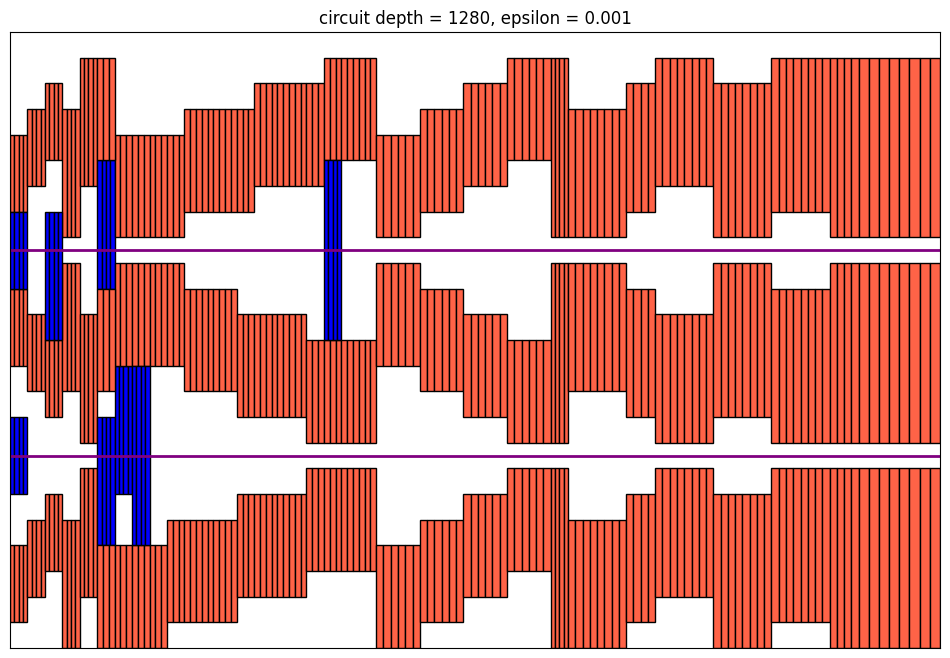

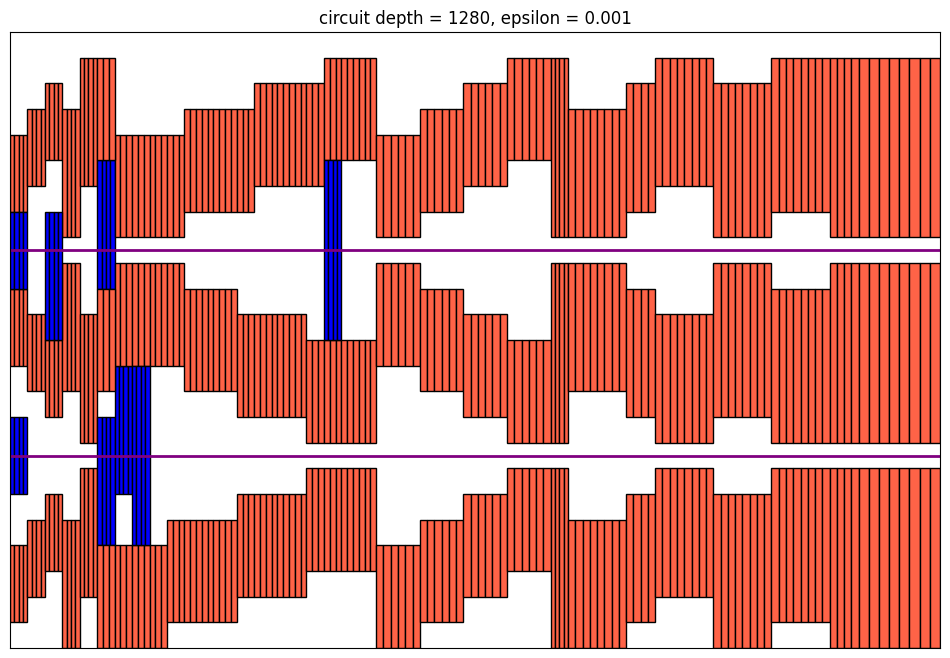

In [9]:
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue",edge=True)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue", edge=True)

In [10]:
def find_inter_module_placed_tiles(placed_tiles_lst, seam_lst):
    inter_placed = []
    for cur_placed_tiles in placed_tiles_lst:
        placed_x, tile = cur_placed_tiles
        w,h,x,y = tile[0]
        for i in range(len(seam_lst)):
            seam = seam_lst[i]
            if y < seam and y+h >= seam:
                inter_placed.append(cur_placed_tiles)
    return inter_placed

[(0, [(6, 3, 0, 6)]), (0, [(6, 3, 0, 14)]), (6, [(6, 3, 0, 6)]), (6, [(6, 3, 0, 14)]), (12, [(6, 3, 0, 6)]), (12, [(6, 3, 0, 14)]), (18, [(6, 3, 0, 6)]), (18, [(6, 3, 0, 14)]), (48, [(6, 5, 0, 12)]), (54, [(6, 5, 0, 12)]), (60, [(6, 5, 0, 12)]), (66, [(6, 5, 0, 12)]), (120, [(6, 5, 0, 4)]), (120, [(6, 5, 0, 14)]), (126, [(6, 5, 0, 4)]), (126, [(6, 5, 0, 14)]), (132, [(6, 5, 0, 4)]), (132, [(6, 5, 0, 14)]), (138, [(6, 5, 0, 4)]), (138, [(6, 5, 0, 14)]), (144, [(6, 5, 0, 6)]), (150, [(6, 5, 0, 6)]), (156, [(6, 5, 0, 6)]), (162, [(6, 5, 0, 6)]), (168, [(6, 7, 0, 4)]), (174, [(6, 7, 0, 4)]), (180, [(6, 7, 0, 4)]), (186, [(6, 7, 0, 4)]), (432, [(6, 7, 0, 12)]), (438, [(6, 7, 0, 12)]), (444, [(6, 7, 0, 12)]), (450, [(6, 7, 0, 12)])]
Construct based on placed tiles


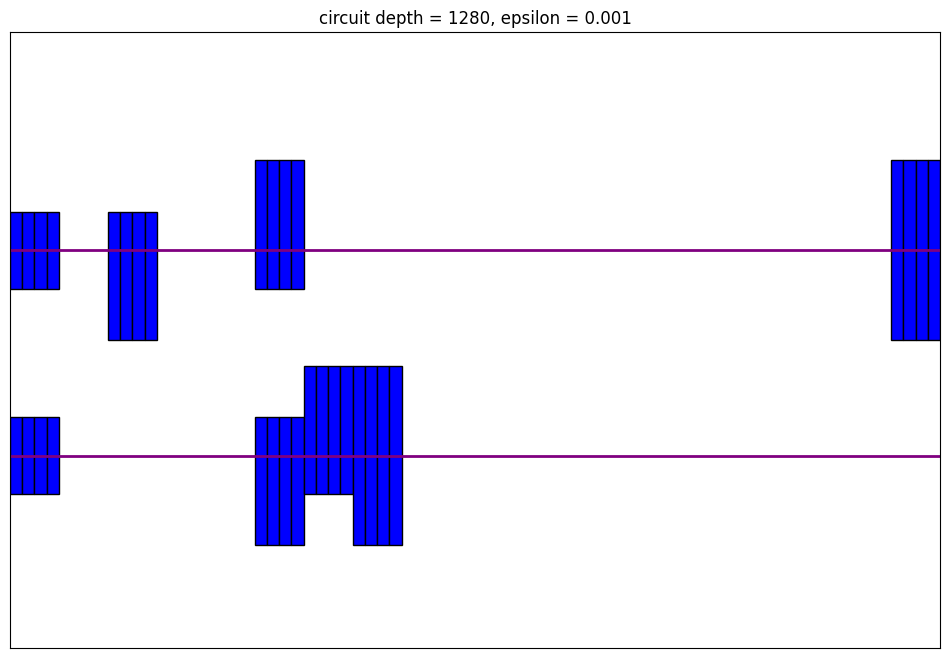

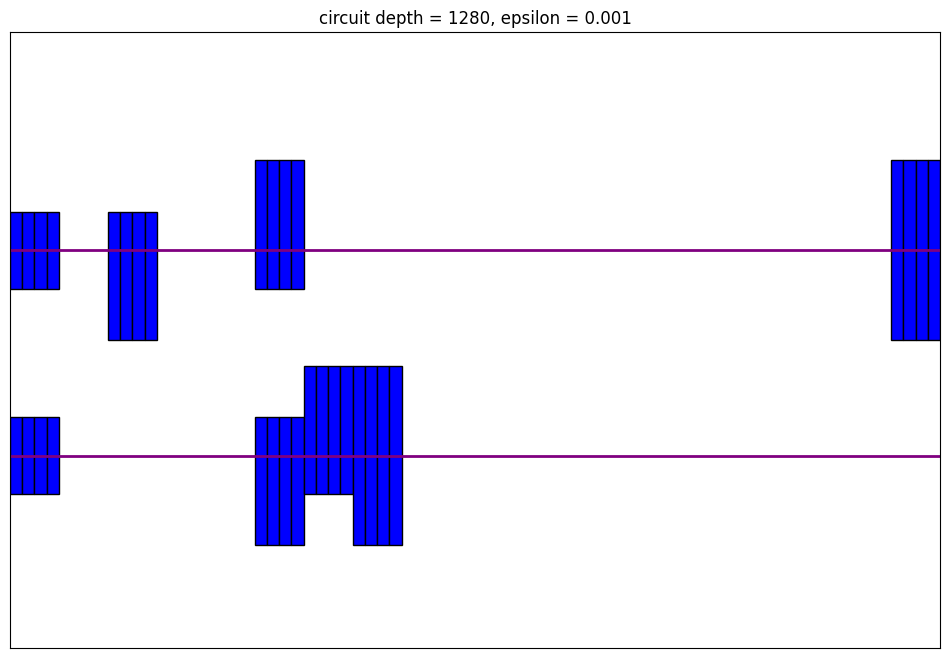

In [11]:
inter_placed_tiles = find_inter_module_placed_tiles(placed_tiles_lst, seam_lst)
inter_placed_tiles = sorted(inter_placed_tiles, key=lambda x: x[0])
print(inter_placed_tiles)
inter_placed_tiles = TilePacker(inter_placed_tiles, bounding_width, N)

inter_placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue", edge=True)
inter_placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue", edge=True)

In [12]:
def find_largest_left_bbox(placed_tiles, x_start, height_threshold, grid_height):
    """
    Find the first bounding box with the largest left boundary x < x_start,
    that spans a height above the threshold. The right boundary can extend beyond x_start.
    Record all tiles inside this bounding box.

    Args:
        placed_tiles: List of (x_position, tile_parts) where tile_parts = [(w, h, dx, dy), ...]
        x_start: The x-position where the bounding box must start searching.
        height_threshold: The minimum height that needs to be covered.
        grid_height: The total height of the grid.

    Returns:
        (x_start, x_end, bounding_width, bbox_height, bbox_tiles)
    """
    # Sort tiles by x-position
    placed_tiles = sorted(placed_tiles, key=lambda x: x[0])

    # Variables to store the best bounding box
    best_bbox = None
    max_search_x = x_start
    # Iterate to find the largest left boundary x < x_start
    while(not best_bbox and max_search_x >= 0):
        for i in range(len(placed_tiles)):
            tile_x, tile = placed_tiles[i]
            # Only consider tiles with x < x_start
            
            if tile_x > max_search_x:
                break
            if tile_x + tile[0][0] <=max_search_x:
                continue
            # Start the bounding box from this leftmost point
            min_x = tile_x
            max_x = tile_x+tile[0][0]
            min_y = float('inf')
            max_y = float('-inf')
            # List to store all tiles inside the bounding box
            bbox_tiles = []
            best_bbox = False
            # Iterate over the tiles and expand the bounding box
            exceed = False
            right_most_index = None
            for j in range(len(placed_tiles)):
                cur_x, cur_tile = placed_tiles[j]
                # Include the current tile if it overlaps with the current bounding box
                for w, h, dx, dy in cur_tile:
                    x_left = cur_x + dx
                    x_right = x_left + w
                    # print(f"x_left is {x_left}")
                    # Check if the tile overlaps horizontally with the current bounding box
                    # print(x_left, x_right, min_x, max_x,"cur")
                    if x_right < min(min_x, x_start):
                        continue
                    if (x_left < max_x and x_left >= min(min_x, x_start)) or (x_right <= max_x and x_right > min(min_x, x_start)):
                        bbox_tiles.append((cur_x, cur_tile))
                        # print(x_left, max_x, cur_x, cur_tile)
                        # Expand the bounding box dimensions
                        if x_right <= max_x:
                            right_most_index = j
                        min_x = min(min_x, x_left)
                        max_x = max(max_x, x_right)
                        min_y = min(min_y, dy)
                        max_y = max(max_y, dy + h)
                    if x_left >= max_x:
                        exceed = True
                    if exceed:
                        break
            # expand to the left to find the left boundary
            added = True
            while(added):
                added = False
                for j in range(right_most_index-1, 0,-1):
                    cur_x, cur_tile = placed_tiles[j]
                    # Include the current tile if it overlaps with the current bounding box
                    for w, h, dx, dy in cur_tile:
                        x_left = cur_x + dx
                        x_right = x_left + w
                        # print(f"x_left is {x_left}")
                        # Check if the tile overlaps horizontally with the current bounding box
                        # print(x_left, x_right, min_x, max_x,"cur")
                        if x_right < min(min_x, x_start):
                            break
                        if (x_left < max_x and x_left >= min(min_x, x_start)) or (x_right <= max_x and x_right > min(min_x, x_start)):
                            if (cur_x, cur_tile) not in bbox_tiles:
                                bbox_tiles.append((cur_x, cur_tile))
                                added = True
                            # Expand the bounding box dimensions
                            if x_left <= min_x:
                                left_most_index = j
                            min_x = min(min_x, x_left)
                            max_x = max(max_x, x_right)
                            min_y = min(min_y, dy)
                            max_y = max(max_y, dy + h)
            # After expanding, check the height
            bbox_height = max_y - min_y
            # print(f"max_x is {max_x}")
            bounding_width = max_x - min_x
            best_bbox = (min_x, max_x, bounding_width, bbox_height, bbox_tiles)
            if best_bbox:
                print("found")
            # Return the best bounding box found once we reach the height threshold and include all tiles
            if best_bbox:
                return best_bbox
        max_search_x -= 1
        print(max_search_x)

    # If no bounding box meets the threshold
    print("Bounding box not found")
    return None, None, 0, 0, []


found
[(0, [(6, 3, 0, 17)]), (0, [(6, 3, 0, 11)]), (0, [(6, 3, 0, 1)]), (0, [(6, 3, 0, 6)]), (0, [(6, 3, 0, 14)])]
6
0
Construct based on placed tiles


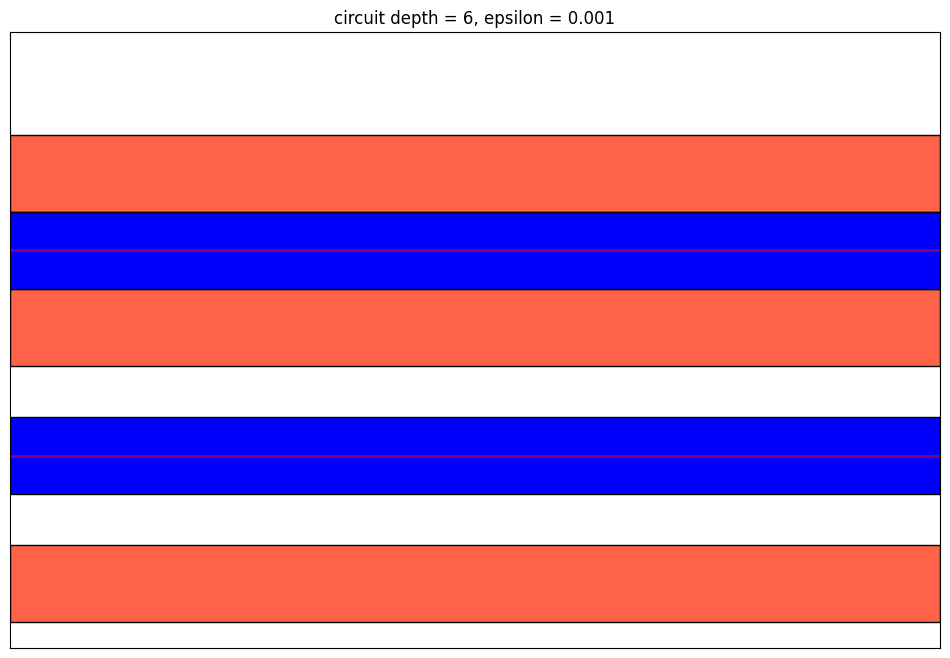

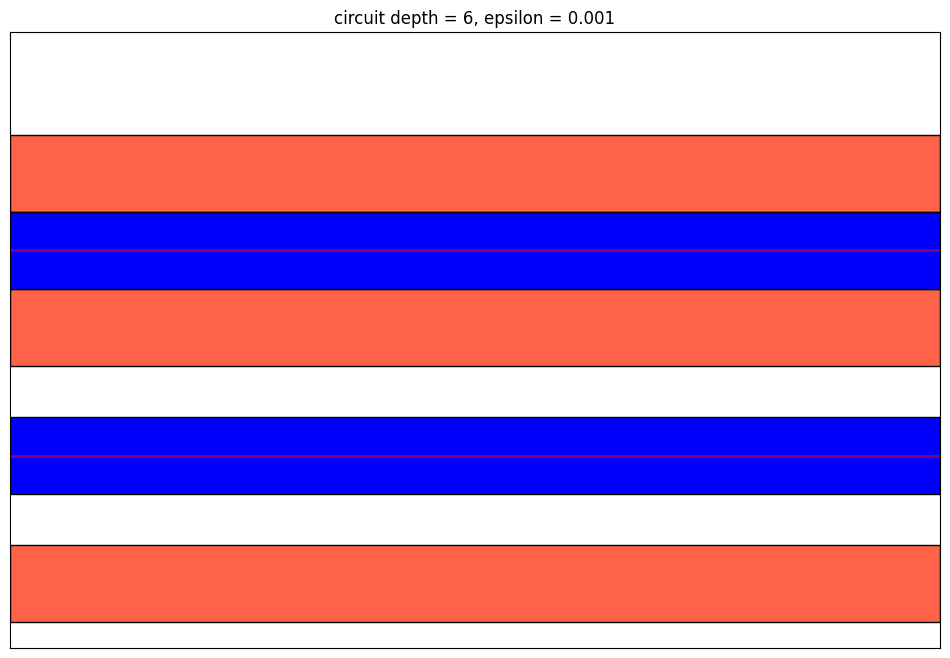

0 6


In [ ]:
best_box = find_largest_left_bbox(placed_tiles_lst, 0, 17, 24)
min_x, max_x, bounding_width, covered_height, bbox_tiles = best_box
print(bbox_tiles)
print(bounding_width)
print(min_x)
bbox = TilePacker(bbox_tiles, bounding_width, N)
bbox.draw_packing([],seam_lst,epsilon,inter_color="blue",edge=True)
bbox.draw_packing([],seam_lst,epsilon,inter_color="blue", edge=True)
print(min_x, max_x)

In [ ]:
def find_all_box(placed_tiles, seam_lst):
    right_most_bc = 0
    box_lst = []
    right_bc = max(placed_x + w for (placed_x, [(w, h, dx, dy)]) in placed_tiles)
    last_visit_tile = 0
    found = True
    while(right_most_bc < right_bc and found):
        found = False
        for i in range(last_visit_tile, len(placed_tiles)):
            cur_x, cur_tile = placed_tiles[i]
            if cur_x <= right_most_bc:
                continue
            # if right_most_bc == 456:
            #     print(right_most_bc,"right")
                # print(cur_x, right_most_bc)
                # print(last_visit_tile, "last visited")
            for w, h, dx, dy in cur_tile:
                for seam in seam_lst:
                    if dy < seam and dy+h >= seam:
                        found = True
                        start_x = cur_x
            if found:
                last_visit_tile = i
                break
        best_box = find_largest_left_bbox(placed_tiles_lst, start_x, 15, 24)
        min_x, max_x, bounding_width, covered_height, bbox_tiles = best_box
        right_most_bc = max(cur_x + w for (cur_x, [(w, h, dx, dy)]) in bbox_tiles)
        box_lst.append(min_x)
        box_lst.append(max_x)
    return box_lst

4656
576
[[[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 16]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 8]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[14, 7, 0, 0]], [[10, 7, 0, 16]], [[10, 7, 0, 16]], [[10, 7, 0, 16]], [[10, 7, 0, 16]], [[10, 7, 0, 8]], [[10, 7, 0, 8]], [[10, 7, 0, 8]], [[10, 7, 0, 8]], [[10, 7, 0, 0]], [[10, 7, 0, 0]], [[10, 7, 0, 0]], [[10, 7, 0, 0]], [[6, 11, 0, 0]], [[6, 11, 0, 0]], [[6, 11, 0, 0]], [[6, 11, 0, 0]], [[6, 11, 0, 4]], [[6, 11, 0, 4]], [[6, 11, 0, 4]], [[6, 11, 0, 4]], [[6, 11, 0, 8]], [[6, 11, 0, 8]], [[6, 11, 0, 8]], [[6, 11, 0, 8]], [[6, 11, 0, 12]], [[6, 11, 0, 12]], [[6, 11, 0, 12]], [[6, 11, 0, 12]], [[10, 6, 0, 16]], [[10, 6, 0, 16]], [[10, 6, 0, 16]], [[10, 6, 0, 16]], [[10, 6, 0, 16]], 

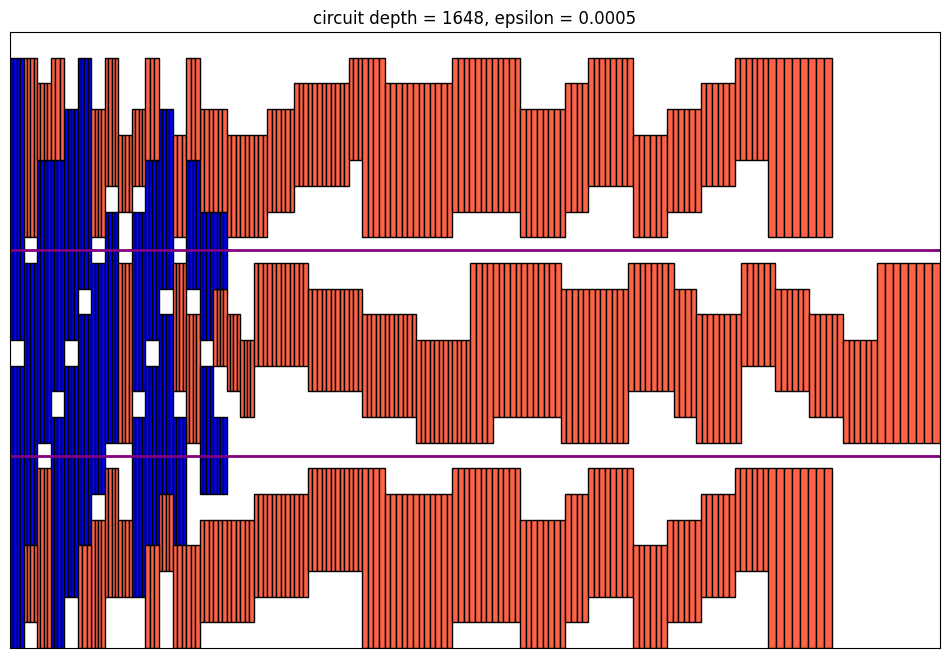

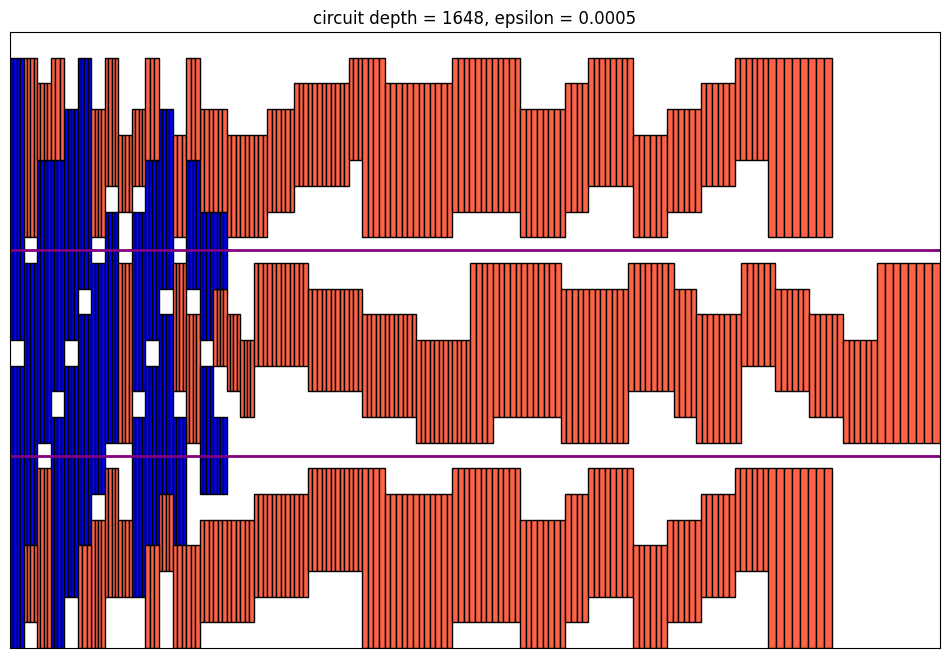

In [ ]:
epsilon = 5e-4
seam_lst = [8,16]
ratio = 1
excitations = create_excitation(uop, all_g, epsilon)
excitations = orbital_reordering(excitations, f_orbs)
tiles = create_circuit_tile(excitations)
tiles = process_tiles(tiles, ratio, seam_lst, ifsorted=True)
print(tiles)
filename = "../test_tiles.txt"
print(f"The length of excitations of epsilon = {epsilon} from raw data is")
print(len(excitations))
tiles = sorted(tiles, key=lambda x: sum(w for w, h, _, _ in x), reverse=False)
# tiles = create_circuit_tile(excitations)
export_tiles_to_file(tiles, filename)

print(os.getcwd())

# Run the C executable directly (assuming it's compiled and named 'tile_packing.exe')
subprocess.run(["./lib/tile_packing.exe", "output.txt"])


filename = '../placed_tiles.txt'
bounding_width, placed_tiles = read_placed_tiles(filename)
print(placed_tiles)
placed_tiles_lst = placed_tiles
placed_tiles = TilePacker(placed_tiles, bounding_width, N)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue",edge=True)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue", edge=True)



In [ ]:
print(placed_tiles_lst)
seam_lst = [8, 16]
box_lst = find_all_box(placed_tiles_lst, seam_lst)
# find_largest_left_bbox(placed_tiles_lst, 2487, 9, 24)

[(0, [(6, 11, 0, 0)]), (6, [(6, 11, 0, 0)]), (12, [(6, 11, 0, 0)]), (18, [(6, 11, 0, 0)]), (24, [(6, 11, 0, 4)]), (30, [(6, 11, 0, 4)]), (36, [(6, 11, 0, 4)]), (42, [(6, 11, 0, 4)]), (48, [(6, 11, 0, 8)]), (54, [(6, 11, 0, 8)]), (60, [(6, 11, 0, 8)]), (66, [(6, 11, 0, 8)]), (0, [(6, 11, 0, 12)]), (6, [(6, 11, 0, 12)]), (12, [(6, 11, 0, 12)]), (18, [(6, 11, 0, 12)]), (72, [(6, 9, 0, 0)]), (78, [(6, 9, 0, 0)]), (84, [(6, 9, 0, 0)]), (90, [(6, 9, 0, 0)]), (96, [(6, 9, 0, 2)]), (102, [(6, 9, 0, 2)]), (108, [(6, 9, 0, 2)]), (114, [(6, 9, 0, 2)]), (120, [(6, 9, 0, 4)]), (126, [(6, 9, 0, 4)]), (132, [(6, 9, 0, 4)]), (138, [(6, 9, 0, 4)]), (144, [(6, 9, 0, 6)]), (150, [(6, 9, 0, 6)]), (156, [(6, 9, 0, 6)]), (162, [(6, 9, 0, 6)]), (168, [(6, 9, 0, 8)]), (174, [(6, 9, 0, 8)]), (180, [(6, 9, 0, 8)]), (186, [(6, 9, 0, 8)]), (72, [(6, 9, 0, 10)]), (78, [(6, 9, 0, 10)]), (84, [(6, 9, 0, 10)]), (90, [(6, 9, 0, 10)]), (96, [(6, 9, 0, 12)]), (102, [(6, 9, 0, 12)]), (108, [(6, 9, 0, 12)]), (114, [(6, 9,

In [ ]:
print(box_lst)

[6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 72, 96, 102, 108, 114, 120, 120, 144, 150, 156, 162, 168, 174, 180, 186, 192, 216, 222, 228, 234, 240, 264, 270, 276, 282, 288, 288, 312, 336, 360, 360, 384, 360, 384]


Bounding width: 1648
[(0, [(6, 11, 0, 0)]), (6, [(6, 11, 0, 0)]), (12, [(6, 11, 0, 0)]), (18, [(6, 11, 0, 0)]), (24, [(6, 11, 0, 4)]), (30, [(6, 11, 0, 4)]), (36, [(6, 11, 0, 4)]), (42, [(6, 11, 0, 4)]), (48, [(6, 11, 0, 8)]), (54, [(6, 11, 0, 8)]), (60, [(6, 11, 0, 8)]), (66, [(6, 11, 0, 8)]), (0, [(6, 11, 0, 12)]), (6, [(6, 11, 0, 12)]), (12, [(6, 11, 0, 12)]), (18, [(6, 11, 0, 12)]), (72, [(6, 9, 0, 0)]), (78, [(6, 9, 0, 0)]), (84, [(6, 9, 0, 0)]), (90, [(6, 9, 0, 0)]), (96, [(6, 9, 0, 2)]), (102, [(6, 9, 0, 2)]), (108, [(6, 9, 0, 2)]), (114, [(6, 9, 0, 2)]), (120, [(6, 9, 0, 4)]), (126, [(6, 9, 0, 4)]), (132, [(6, 9, 0, 4)]), (138, [(6, 9, 0, 4)]), (144, [(6, 9, 0, 6)]), (150, [(6, 9, 0, 6)]), (156, [(6, 9, 0, 6)]), (162, [(6, 9, 0, 6)]), (168, [(6, 9, 0, 8)]), (174, [(6, 9, 0, 8)]), (180, [(6, 9, 0, 8)]), (186, [(6, 9, 0, 8)]), (72, [(6, 9, 0, 10)]), (78, [(6, 9, 0, 10)]), (84, [(6, 9, 0, 10)]), (90, [(6, 9, 0, 10)]), (96, [(6, 9, 0, 12)]), (102, [(6, 9, 0, 12)]), (108, [(6, 9, 0,

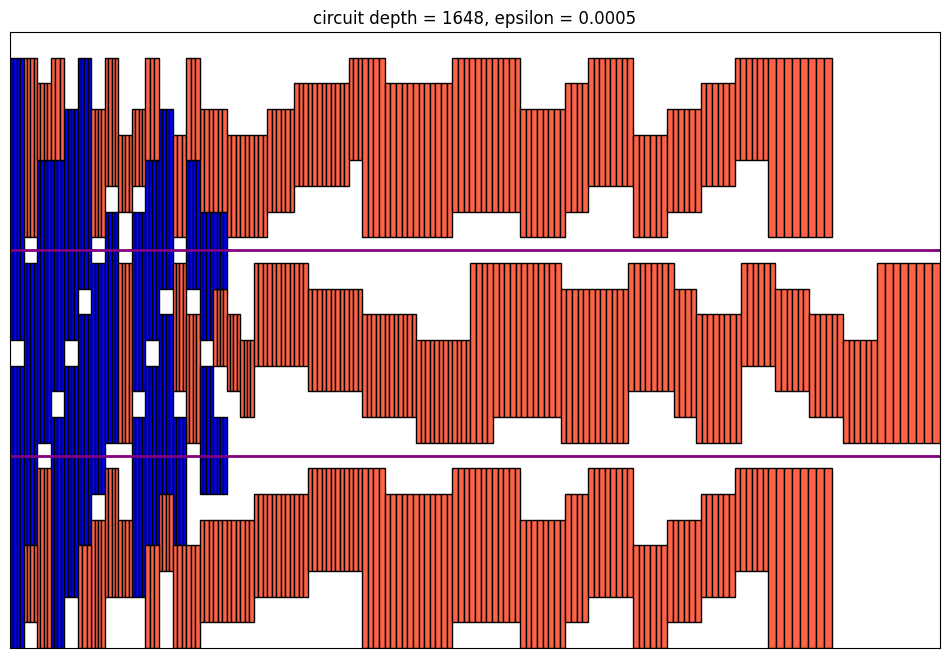

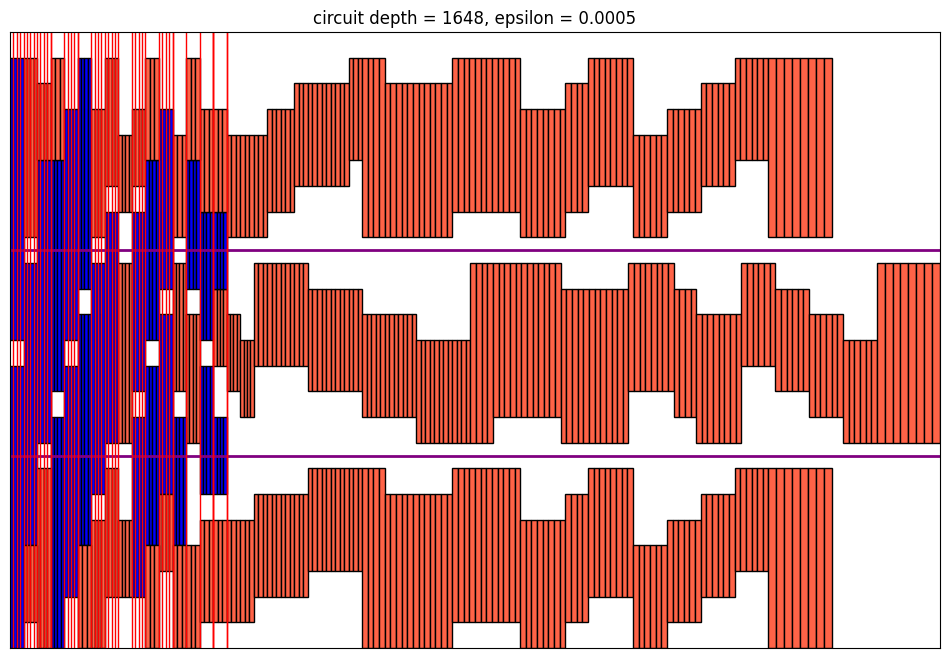

In [ ]:
bounding_width, placed_tiles = read_placed_tiles(filename)
print(placed_tiles)
print(box_lst)
placed_tiles_lst = placed_tiles
placed_tiles = TilePacker(placed_tiles, bounding_width, N)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue",edge=True)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue", edge=True, box_lst=box_lst,xmin=0)